In [1]:
import pandas as pd
import xarray as xr
import requests
import matplotlib.pyplot as plt
import shapely
import geopandas as gpd
import metpy
import numpy as np

## Wind Report stuffs 
    
### Main Methods 
    
    1) get_wind_reports (datetime) 
        input: datetime
        output: Returns pd df with wind reports for given day
        
    2) get_weather_reports (start_date, end_date) 
        input: start_date, end_date pd datetime
        output: returns wind reports in given date range
        
    3) filter_reports (df, center_event, distance, time)
        input: wind_report df, center_event, distance, time
        output: df with spatially and temporally filtered storm reports
    
    Useful helper functions
    
    4) filters_temporally
    5) filter_spatially

In [2]:
#Returns pandas dataframe with wind reports for given date range
def get_weather_reports(start_date, end_date):    
    i = 0
    for date in generate_days(start_date, end_date):
        df = get_wind_reports(date)
        if i == 0:
            big_df = df
            i += 1
        else :
            big_df = pd.concat([big_df, df])
    big_df.reset_index(inplace=True)
    return big_df


#Gets wind report on given date as a pandas dataframe
def get_wind_reports(datetime):
    date = datetime.strftime("%y%m%d")
    df = request_wind_report_df(date)    
    df = add_datetime(df, datetime)
    return df

#Helper functions 
#Requests the wind report from the NOAA website and cleans up the data
def request_wind_report_df(date):
    #Actual request
    link = generate_link(date)
    data = requests.get(link)
    #Turns csv string into dataFrame
    csv_string = data.text
    data = [row.split(',') for row in csv_string.split('\n')]
    data.pop(-1)
    columns = data.pop(0)
    data.pop(0)
    #Returns dataframe 
    df = pd.DataFrame(data, columns=columns)
    df["Lat"] = df["Lat"].astype("float")
    df["Lon"] = df["Lon"].astype("float")
    return df

#Adds date time column to the dataframe
def add_datetime(df, datetime):
    time = df["Time"]
    #TODO: Rename foo function
    df["datetime"] = [foo(datetime, t) for t in time]
    df['datetime'] = pd.to_datetime(df["datetime"])
    #Removes Time column
    df.drop(columns=["Time"], inplace=True)
    return df 

#Corrects the date for a given report
#TODO: Rename this function
def foo(datetime, time):
    day = datetime.day if int(time[0] + time[1]) >= 12 else (datetime + pd.Timedelta(days = 1)).day
    dt = pd.Timestamp(year=datetime.year, month=datetime.month,
                                   day=day, hour=int(time[0] + time[1]),
                                  minute = int(time[2] + time[3]))
    return dt



#Generates link to csv download of wind report on given date. Date format "yymmdd"
def generate_link(date):
    return f'https://www.spc.noaa.gov/climo/reports/{date}_rpts_wind.csv'

#Generates dates in format "yymmdd"
def generate_days(start_date, end_date):
    
    days = pd.period_range(start=start_date, end=end_date)
    # days = [day.strftime("%y%m%d") for day in days]
    return days


In [3]:
#Applies filters to the storm report dataset
def filter_reports(df, center_event, distance, hours):
    spatially_filtered = spatial_filter(df, center_event["Lat"], center_event["Lon"], distance)
    temporally_filtered = temporal_filter(spatially_filtered, hours,center_event["datetime"], )
    return temporally_filtered

#Filters the storm reports so that only the ones that are +- hours from the given date time
def temporal_filter(df, hours, date_time):
    filtered_df = df[df["datetime"] >= (date_time - pd.Timedelta(hours=hours))]
    time_filtered_events = filtered_df[filtered_df["datetime"] <= (date_time + pd.Timedelta(hours=hours))]
    return time_filtered_events

#Filters storm reports so that only the ones that are +- distance from given lat/lon
#TODO: Enhance so that we can give the distance in kilometers
def spatial_filter(df, lat, lon, distance):
    lat_filtered_df = latitude_filter(df, lat, distance)
    filtered_df = longitude_filter(lat_filtered_df, lon, distance)
    return filtered_df

#Helper functions for the spatial filter
def latitude_filter(df, lat, distance):
    val = lat + distance
    lat_filtered = df[df["Lat"] <= val]
    lat_filtered = lat_filtered[lat_filtered["Lat"] >= lat - distance]
    return lat_filtered

def longitude_filter(df, lon, distance):
    lon_filtered = df[df["Lon"] <= lon + distance]
    lon_filtered = lon_filtered[lon_filtered["Lon"] >= lon - distance]
    return lon_filtered
    

## RRFS Stuffs

### Main Method

    1) fetch_rrfs_forecast (storm_report, forecast_hours, bounding_box, variable_list)
        inputs:
            storm_report : 
            forecast_hours :
            bounding_box : 
            variable_list : list of variables to extract 
        output: 
            xarray dataset 

In [359]:
from rrfs import rrfs
r = rrfs.Rrfs()

#Inputs storm_report row and the forecast hour
#Outputs xarray dataset with model forecast
#TODO: Needs to be updated
def fetch_rrfs_forecast(event_datetime, forecast_hour, bounding_box=False,variable_list=False):
    event_datetime| - pd.Timedelta(hours=forecast_hour)
    return r.fetch_model_outputs(initialization_date, forecast_hour, bounding_box, variable_list)
   

## Plots 


In [5]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#Plots weather reports
def plot_storm_reports(events, center_event=False, distance=1, surrogate=False):

    figure = plt.figure()
    
    ax = figure.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES)
    ax.set_extent(
        [-125, -75, 25, 50],
        crs=ccrs.PlateCarree()
    )

    if surrogate:
        color = 'blue'
    else :
        color = 'red'
    
    plt.scatter(
        x = events["Lon"],
        y = events["Lat"],
        color=color,
        s=2,
        alpha=1,
        transform=ccrs.PlateCarree()
    )
    if center_event:
        plt.scatter(
            x = center_event["Lon"],
            y = center_event["Lat"],
            color="green",
            s=4,
            alpha=1,
            transform=ccrs.PlateCarree()
        )

    plt.show()

In [6]:
# Wind Speed Calculation

import matplotlib.pyplot as plt
import metpy.calc as mpcalc

#Plots winds speed and 
def plot_wind_speed(ds, interesting_events, center_event, offset=3):

    # Calculate the total deformation of the flow
    wind_speed = mpcalc.wind_speed(ds.UGRD_P0_L103_GLC0, ds.VGRD_P0_L103_GLC0)
    # start figure and set axis
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # plot wind speed
    cf = ax.contourf(ds.coords['gridlon_0'], 
                     ds.coords['gridlat_0'], 
                     wind_speed, cmap=plt.cm.BuPu)
    plt.colorbar(cf, pad=0, aspect=50)
    ax.barbs(ds.coords['gridlon_0'][0::offset, 0::offset],
             ds.coords['gridlat_0'][0::offset, 0::offset],
             ds.UGRD_P0_L103_GLC0[0::offset, 0::offset], 
             ds.VGRD_P0_L103_GLC0[0::offset, 0::offset], 
             color='black', length=5, alpha=0.5)
   
    ax.set_title('Wind Speed Calculation')
    
    plt.scatter(
            x = interesting_events["Lon"],
            y = interesting_events["Lat"],
            color="red",
            s=2,
            alpha=1
        )
    
    plt.scatter(
        x=center_event["Lon"],
        y=center_event["Lat"],
        color="Orange",
        s=5
    )
    plt.show()

#Plots the max wind speed variable
def plot_max_wind_speed(ds, interesting_events, center_event, offset=3):

    # Calculate the total deformation of the flow
    wind_speed = mpcalc.wind_speed(ds.MAXUW_P8_L103_GLC0_max1h, ds.MAXVW_P8_L103_GLC0_max1h)
    # start figure and set axis
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # plot wind speed
    cf = ax.contourf(ds.coords['gridlon_0'], 
                     ds.coords['gridlat_0'], 
                     wind_speed, cmap=plt.cm.YlGn)
    plt.colorbar(cf, pad=0, aspect=50)
    ax.barbs(ds.coords['gridlon_0'][0::offset, 0::offset],
             ds.coords['gridlat_0'][0::offset, 0::offset],
             ds.UGRD_P0_L103_GLC0[0::offset, 0::offset], 
             ds.VGRD_P0_L103_GLC0[0::offset, 0::offset], 
             color='black', length=5, alpha=0.5)
   
    ax.set_title('Max Wind Speed')
    
    plt.scatter(
            x = interesting_events["Lon"],
            y = interesting_events["Lat"],
            color="red",
            s=2,
            alpha=1
        )
    
    plt.scatter(
        x=center_event["Lon"],
        y=center_event["Lat"],
        color="Orange",
        s=5
    )
    plt.show()


def contour_plot(ds, interesting_events, center_event, variable):
    #Plots the max wind speed variable
    # Calculate the total deformation of the flow
    # wind_speed = mpcalc.wind_speed(ds.MAXUW_P8_L103_GLC0_max1h, ds.MAXVW_P8_L103_GLC0_max1h)
    # start figure and set axis
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # plot wind speed
    cf = ax.contourf(ds.coords['gridlon_0'], 
                     ds.coords['gridlat_0'], 
                     ds[variable], cmap=plt.cm.Purples)
    plt.colorbar(cf, pad=0, aspect=50)
    ax.set_title('Name')
    
    plt.scatter(
            x = interesting_events["Lon"],
            y = interesting_events["Lat"],
            color="red",
            s=2,
            alpha=1
        )
    
    plt.scatter(
        x=center_event["Lon"],
        y=center_event["Lat"],
        color="Orange",
        s=5
    )
    plt.show()

def plot_gust_potential(ds, interesting_events, center_event, offset=3):
    #Plots the max wind speed variable
    # Calculate the total deformation of the flow
    # wind_speed = mpcalc.wind_speed(ds.MAXUW_P8_L103_GLC0_max1h, ds.MAXVW_P8_L103_GLC0_max1h)
    # start figure and set axis
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # plot wind speed
    cf = ax.contourf(ds.coords['gridlon_0'], 
                     ds.coords['gridlat_0'], 
                     ds.GUST_P0_L1_GLC0, cmap=plt.cm.YlGn)
    plt.colorbar(cf, pad=0, aspect=50)
    ax.set_title('Gust Potential')
    
    plt.scatter(
            x = interesting_events["Lon"],
            y = interesting_events["Lat"],
            color="red",
            s=2,
            alpha=1
        )
    
    plt.scatter(
        x=center_event["Lon"],
        y=center_event["Lat"],
        color="Orange",
        s=5
    )
    plt.show()
    

## Slice Stuffs

In [7]:
from sklearn.cluster import DBSCAN
#Class that represents individual slice
class spatial_slice:
    def __init__(self, df, center, bounding_box, bin_start, bin_size):
        self.df = df #pandas dataframe with reports
        self.center = center #Report used as center for slice
        self.bounding_box = bounding_box #Shapely object
        #Metadata 
        self.bin_start = bin_start #Date time of bin start
        self.bin_size = bin_size #Number of hours in bin

    def plot(self):

        extent = 2
        figure = plt.figure()
    
        ax = figure.add_subplot(1,1,1,projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.STATES)
        ax.set_extent(
            [self.center["Lon"] - extent, 
             self.center["Lon"] + extent, 
             self.center["Lat"] - extent, 
            self.center["Lat"] + extent],
            crs=ccrs.PlateCarree()
        )
        ax.scatter(
            x = self.df["Lon"],
            y = self.df["Lat"],
            color="red",
            s=2,
            alpha=1,
            transform=ccrs.PlateCarree()
        )
        
        ax.scatter(
            x = self.center["Lon"],
            y = self.center["Lat"],
            color="green",
            s=4,
            alpha=1,
            transform=ccrs.PlateCarree()
        )

        x,y = self.bounding_box.exterior.xy
        ax.plot(x,y, transform=ccrs.PlateCarree())
        plt.show()
        return
    

In [8]:
#Generates the slices for reports in a given timebin
def get_slices(time_bin_df, bin_start, bin_size, distance=1):
    slices = []
    #TODO: Algorithm to generate slices can be better
    while time_bin_df.size > 0:
        #Algorithm arbitratily chooses first report as center for the slice
        center = time_bin_df.loc[0]
        #Spatially filters dataframe
        data = spatial_filter(time_bin_df, center["Lat"], center["Lon"], distance)
        #Gets a bounding box
        bounding_box = get_bounding_box(center, distance)
        s = spatial_slice(data, center, bounding_box, bin_start, bin_size)
        slices.append(s)
        #Removes from df the reports that are in current slice
        time_bin_df = time_bin_df[~time_bin_df.index.isin(s.df.index)]
        #Resets index so the loop works
        time_bin_df = time_bin_df.reset_index(drop=True)
        
    return slices


In [9]:
#Adds time bin column to each daily report
def add_time_bins(daily_reports, day_datetime, bin_size=3):
    
    hourly_bins = make_time_bins(day_datetime, bin_size)
    bins = []
    
    #For each report, 
    for row in daily_reports.iterrows():
        
        bins.append(get_bin(row[1], hourly_bins, bin_size))
    daily_reports["bins"] = bins

    return daily_reports

#Returns the correct bin for a given row 
def get_bin(report, hourly_bins, bin_size):
    time = report["datetime"]
    for bin in hourly_bins:
        if time.hour - bin.hour < bin_size:
            return bin
    return 

#Helper functions

#Generates the time bins
def make_time_bins(day_datetime, bin_size):
    start = pd.Timestamp(year=day_datetime.year, month=day_datetime.month, day=day_datetime.day, hour=0)
    end = pd.Timestamp(year=day_datetime.year, month=day_datetime.month, day=day_datetime.day, hour=23)
    return pd.date_range(start, end, freq=f'{bin_size}H')
    # return 
    
#Returns bounding box shapely object centered on center event
def get_bounding_box(center_event, size):
    lat = center_event["Lat"]
    lon = center_event["Lon"]
    b = shapely.box(lon - size, lat - size, lon + size, lat + size)
    return b

In [10]:
def plot_bin_slices()

SyntaxError: invalid syntax (1136080706.py, line 1)

In [348]:
day = pd.Timestamp(2023,6,14)
wind_reports = get_wind_reports(day)
bins = make_time_bins(day, bin_size=3)
print(bins)
wind_reports = add_time_bins(wind_reports, day, bin_size=3)

DatetimeIndex(['2023-06-14 00:00:00', '2023-06-14 03:00:00',
               '2023-06-14 06:00:00', '2023-06-14 09:00:00',
               '2023-06-14 12:00:00', '2023-06-14 15:00:00',
               '2023-06-14 18:00:00', '2023-06-14 21:00:00'],
              dtype='datetime64[ns]', freq='3H')


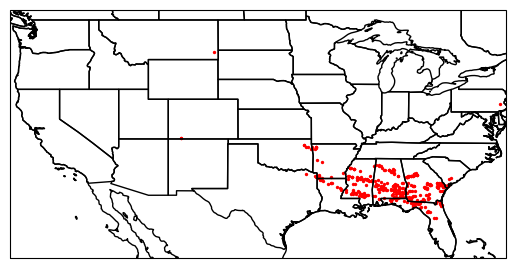

In [349]:
plot_storm_reports(wind_reports)


In [350]:
grouped_reports = wind_reports.groupby('bins')
grouped_reports.describe()

Lat                                              \
                     count       mean       std    min      25%    50%   
bins                                                                     
2023-06-14 00:00:00   84.0  31.483810  2.391676  29.76  30.5000  30.90   
2023-06-14 03:00:00   17.0  31.440000  2.377538  29.03  29.6300  31.04   
2023-06-14 06:00:00    8.0  32.000000  0.413107  31.59  31.8650  31.90   
2023-06-14 09:00:00    4.0  31.395000  0.302600  31.11  31.1550  31.37   
2023-06-14 12:00:00   27.0  34.278889  1.881692  31.47  32.1550  34.10   
2023-06-14 15:00:00   25.0  33.843200  1.554868  32.04  33.2300  33.80   
2023-06-14 18:00:00  101.0  33.717426  2.394533  31.44  32.9100  33.18   
2023-06-14 21:00:00  140.0  32.499571  2.178899  30.99  31.6875  32.16   

                                       Lon                               \
                         75%    max  count       mean       std     min   
bins                                                                      
2023-06-14 00:00:00  31.3525  45.81   84.0 -84.432262  4.008069 -104.46   
2023-06-14 03:00:00  32.2100  37.14   17.0 -87.725882  7.800084 -107.76   
2023-06-14 06:00:00  31.9375  32.98    8.0 -87.388750  1.607371  -90.97   
2023-06-14 09:00:00  31.6100  31.73    4.0 -84.995000  0.326037  -85.25   
2023-06-14 12:00:00  36.1600  36.38   27.0 -89.512593  5.347976  -95.36   
2023-06-14 15:00:00  34.0000  40.69   25.0 -88.104400  4.614392  -95.20   
2023-06-14 18:00:00  33.4200  42.73  101.0 -87.026535  5.009631  -93.89   
2023-06-14 21:00:00  32.3800  42.85  140.0 -84.798429  4.381298  -94.09   

                                                     
                        25%     50%      75%    max  
bins                                                 
2023-06-14 00:00:00 -86.300 -84.230 -82.8225 -70.48  
2023-06-14 03:00:00 -88.090 -85.690 -82.9800 -82.09  
2023-06-14 06:00:00 -87.620 -87.225 -86.3550 -85.77  
2023-06-14 09:00:00 -85.175 -85.105 -84.9250 -84.52  
2023-06-14 12:00:00 -94.405 -90.730 -83.2050 -81.90  
2023-06-14 15:00:00 -90.370 -87.830 -84.8300 -74.38  
2023-06-14 18:00:00 -90.060 -86.810 -84.5700 -72.10  
2023-06-14 21:00:00 -87.680 -85.325 -81.7800 -70.83

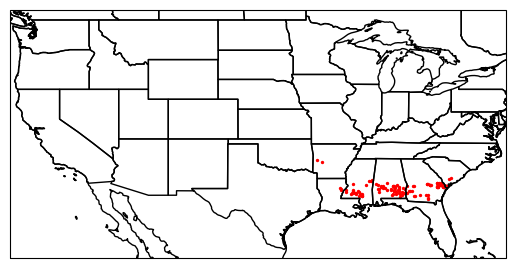

In [351]:
time_window = grouped_reports.get_group(bins[-1])
time_window = time_window.reset_index(drop=True)
plot_storm_reports(time_window)

In [352]:
from geopy.distance import geodesic as GD
from math import radians

def get_clusters(time_window_df):

    X = time_window_df["Lon"].values
    Y = time_window_df["Lat"].values
    points = np.array([[X[i],Y[i]] for i in range(len(X))])


    
    dist_matrix = np.zeros((len(X), len(Y)))

    #Computes the distance matrix 
    #Slow
    for i in range(len(X)):
        for j in range(len(Y)):
            p = (X[i], Y[j])
            dist_matrix[i,j] = GD((Y[i], X[i]), (Y[j], X[j])).km

    
    db = DBSCAN(eps = 40, min_samples=1, metric="precomputed").fit(dist_matrix)
    labels = db.labels_

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)


    clusters = {}
    for i in range(n_clusters_):
        clusters[i] = []


    for i in range(len(labels)):
        clusters[labels[i]].append(points[i])
    
    actual_clusters = []
    for c in clusters.keys():
        aa = np.array(clusters[c])
        C = cluster(aa)
        actual_clusters.append(C)
    return actual_clusters

clusters = get_clusters(time_window)
print(clusters)


[<__main__.cluster object at 0x7f146de56bb0>, <__main__.cluster object at 0x7f146f9eac10>, <__main__.cluster object at 0x7f146f5fa6a0>, <__main__.cluster object at 0x7f146f5fa700>, <__main__.cluster object at 0x7f146f5fa6d0>, <__main__.cluster object at 0x7f146f5fa730>, <__main__.cluster object at 0x7f146f5fa7c0>, <__main__.cluster object at 0x7f146f5fa820>, <__main__.cluster object at 0x7f146f5fa880>, <__main__.cluster object at 0x7f146f5fa8e0>, <__main__.cluster object at 0x7f146f5fa940>, <__main__.cluster object at 0x7f146f5fa9a0>, <__main__.cluster object at 0x7f146f5faa00>, <__main__.cluster object at 0x7f146f5faa60>, <__main__.cluster object at 0x7f146f5faac0>, <__main__.cluster object at 0x7f146f5fab20>, <__main__.cluster object at 0x7f146f5fab50>, <__main__.cluster object at 0x7f146f55b700>, <__main__.cluster object at 0x7f146f55b550>, <__main__.cluster object at 0x7f146f55b7c0>]


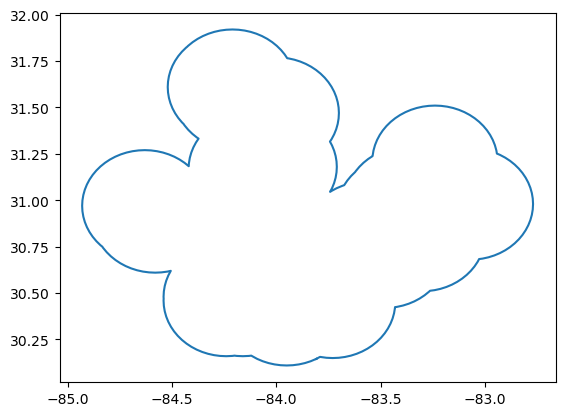

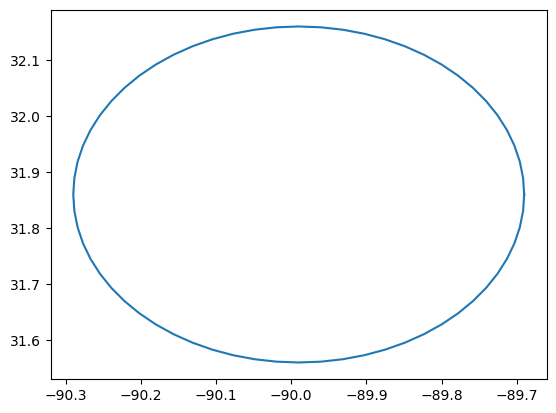

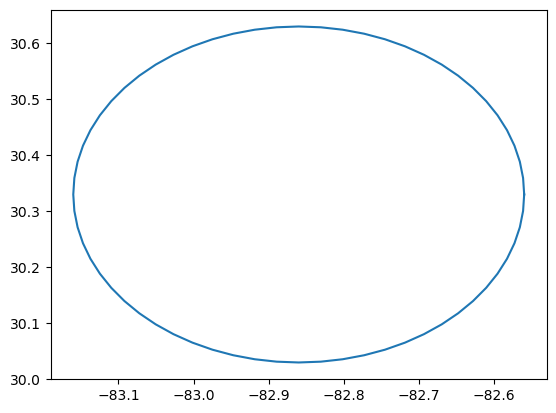

In [332]:
for c in clusters:
    c.plot()

In [372]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d


class cluster:
    def __init__(self, points):
        self.points = points
        self.shape = self.get_shape(points)
        self.area = self.shape.area
        # self.hull = self.get_convex_hull(self.points)
    
    def get_shape(self, points):  
        polygons = []
        for i in range(len(points)):
            circle = Point(points[i,0], points[i,1]).buffer(.3)
            polygons.append(circle)
        union = unary_union(polygons)
        return union
 
    def plot(self):
        # print(self.shape.exterior.xy)
        x,y = self.shape.exterior.xy
        plt.plot(x,y)
        plt.show()
        return 
    

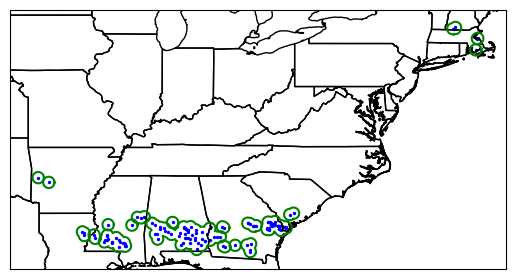

In [373]:
def plot_clusters(time_window_df, clusters):
    
    figure = plt.figure()
    X = time_window_df["Lon"].values
    Y = time_window_df["Lat"].values
    points = np.array([[X[i],Y[i]] for i in range(len(X))])
    
    ax = figure.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES)
    # ax.set_extent(
    #     [-125, -70, 20,50],
    #     crs=ccrs.PlateCarree()
    # )

    for point in points:
        plt.scatter(
            x = point[0],
            y = point[1],
            color='blue',
            s=2,
            alpha=1,
            transform=ccrs.PlateCarree()
        )
        # x,y = s.bounding_box.exterior.xy
        # plt.plot(x,y, color='purple')

    for c in clusters:
        x,y = c.shape.exterior.xy
        plt.plot(x,y, color='green')
    plt.show()
    return 

def ploooooot(time_window_df, clusters, surrogate_time_window, surrogate_clusters):
    figure = plt.figure()
    X = time_window_df["Lon"].values
    Y = time_window_df["Lat"].values
    points = np.array([[X[i],Y[i]] for i in range(len(X))])
    
    sX = surrogate_time_window["Lon"].values
    sY = surrogate_time_window["Lat"].values
    spoints = np.array([[sX[i],sY[i]] for i in range(len(sX))])
    
    ax = figure.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES)
    # ax.set_extent(
    #     [-125, -70, 20,50],
    #     crs=ccrs.PlateCarree()
    # )

    for point in points:
        plt.scatter(
            x = point[0],
            y = point[1],
            color='blue',
            s=2,
            alpha=1,
            transform=ccrs.PlateCarree()
        )
        # x,y = s.bounding_box.exterior.xy
        # plt.plot(x,y, color='purple')

    for c in clusters:
        x,y = c.shape.exterior.xy
        plt.plot(x,y, color='green')
    
    for point in spoints:
        plt.scatter(
            x = point[0],
            y = point[1],
            color='red',
            s=2,
            alpha=1,
            transform=ccrs.PlateCarree()
        )
        # x,y = s.bounding_box.exterior.xy
        # plt.plot(x,y, color='purple')

    for c in surrogate_clusters:
        x,y = c.shape.exterior.xy
        plt.plot(x,y, color='purple')
    
    plt.show()
    return 

plot_clusters(time_window, clusters)

In [374]:
union = unary_union(polygons)
x,y = union.exterior.xy
plt.plot(x,y)

/home/andres/anaconda3/envs/andres/lib/python3.9/site-packages/shapely/set_operations.py:406: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  geometries = np.asarray(geometries)


TypeError: One of the arguments is of incorrect type. Please provide only Geometry objects.

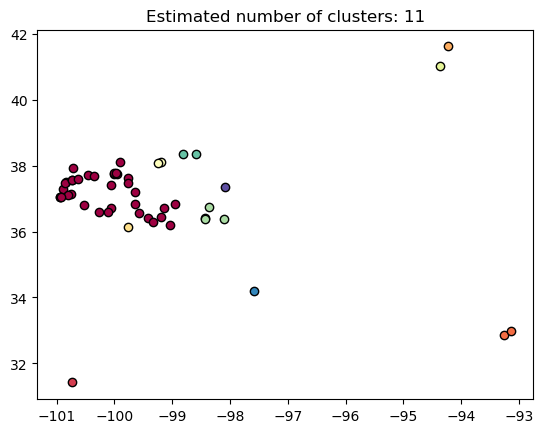

In [375]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = points[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:,0],
        xy[:,1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

    xy = points[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:,0],
        xy[:,1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

In [1]:
# distance = 1
# storm_report_slices = get_slices(bin_reports, bins[1], 3, distance)
# print(len(storm_report_slices))
# for s in storm_report_slices:
#     s.plot()

In [369]:
# UH = 
# downwhatever = 

#Takes the dataset with uwind and vwind and generates dataset with wind
def make_wind_dt(dt):
    wind_dt = xr.Dataset(
            data_vars=dict(
                wind=(["ygrid_0", "xgrid_0"], 
                      ((dt.MAXUW_P8_L103_GLC0_max1h.data)**2 + (dt.MAXUW_P8_L103_GLC0_max1h.data)**2)**(1/2)),
                land=(["ygrid_0", "xgrid_0"],
                     dt.LAND_P0_L1_GLC0.data)
            ),
            coords=dict(
                gridlat_0=(["ygrid_0", "xgrid_0"], dt.coords['gridlat_0'].data),
                gridlon_0=(["ygrid_0", "xgrid_0"], dt.coords['gridlon_0'].data)
            )
        )
    return wind_dt

def get_surrogate_storm_reports(bin_datetime, bin_size, variable_list, thresholds, forecast_h):
    surrogate_report_list = []
    init_hour = pd.Timestamp(bin_datetime) - pd.Timedelta(hours=forecast_h)
    f_hour = bin_datetime
    
    model_outputs = r.fetch_model_outputs(
        init_hour, 
        [forecast_h, forecast_h + 1, forecast_h + 2], 
        variable_list=variable_list + ["LAND_P0_L1_GLC0"] #Land cover is hardcoded
    )
    #Make the new dataframe with wind as a variable
    for output in model_outputs:
        #TODO: Filter the rest of the variables 
        
        #If variable is wind, 
        #For loop over the variable list 
        wind_dt = make_wind_dt(output)
        filtered_output = wind_dt.where(wind_dt.land == 1, drop=True)
        filtered_output = filtered_output.where(filtered_output.wind > thresholds["wind"], drop=True)
        

        filtered_output = filtered_output.to_dataframe().reset_index()
        #TODO: Include the rest of the variables in this dict 
        t_df = pd.DataFrame(
            {'wind': filtered_output['wind'], 
             'Lat': filtered_output['gridlat_0'], 
             'Lon': filtered_output['gridlon_0']
            }
        )
        surrogate_report = t_df.dropna().reset_index(drop=True)
        surrogate_report_list.append(surrogate_report)
    
    surrogate_df = pd.concat(surrogate_report_list)
    surrogate_df.index = pd.RangeIndex.from_range(range(len(surrogate_df.index)))
    return surrogate_df

thresholds = {"wind":30}
U_10m = "MAXUW_P8_L103_GLC0_max1h"
V_10m = "MAXVW_P8_L103_GLC0_max1h"
UH_2_5 = "MXUPHL_P8_2L103_GLC0_max1h"
variable_list = [U_10m, V_10m]
surrogate_reports_df = get_surrogate_storm_reports(bin_datetime=bins[-1], 
                                                bin_size=3, 
                                                variable_list=variable_list, 
                                                thresholds=thresholds,
                                                forecast_h=3)
print(surrogate_reports_df)

         wind        Lat         Lon
0   30.789518  32.921127  -91.551048
1   32.999226  32.919392  -91.519127
2   32.910839  32.946186  -91.517044
3   34.068851  28.369495  -80.586945
4   32.566250  28.395624  -80.581421
..        ...        ...         ...
87  30.658619  46.333084 -107.353851
88  30.128288  46.335934 -107.315376
89  31.012173  46.351028 -107.473434
90  30.923784  46.353912 -107.434952
91  30.305065  46.356785 -107.396469

[92 rows x 3 columns]


In [370]:
surrogate_clusters = get_clusters(surrogate_reports_df)

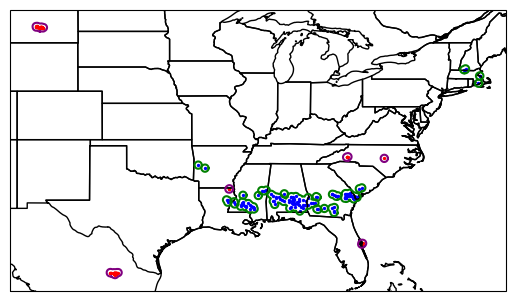

In [371]:
ploooooot(time_window, clusters, surrogate_reports_df, surrogate_clusters)

In [188]:
class time_window:
    def __init__(self, storm_report_neighborhood, rrfs_surrogate_neighborhood_dict):
        
        self.storm_report_neighborhood = storm_report_neighborhood
        self.rrfs_surrogate_neighborhood_dict = rrfs_surrogate_neighborhood_dict
    
    def plot(self, variable):
        #Input validation
        if variable not in self.rrfs_surrogate_neighborhood_dict.keys():
            raise Exception("Wrong variable")
        else :
            self.beeeg_plot(self.rrfs_surrogate_neighborhood_dict[variable])
            return 
    
    def analysis(self, variable):
        surrogate_slices = self.rrfs_surrogate_neighborhood_dict[variable]
        storm_report_slices = self.storm_report_neighborhood
        print(f"surrogate neighborhoods {len(surrogate_slices)}")
        print(f"storm report neighborhoods {len(storm_report_slices)}")

        #Hits and misses
        overlaps = [0]*len(storm_report_slices)
        for i in range(len(storm_report_slices)):
            for j in range(len(surrogate_slices)):
                if storm_report_slices[i].bounding_box.intersects(surrogate_slices[j].bounding_box):
                    overlaps[i] = 1

        hits = np.array(overlaps).sum()
        misses = len(storm_report_slices) - hits
        #False alarms
        # overlaps = [0]*len(surrogate_slices)
        # count = 0
        overlaps = [0]*len(surrogate_reports)
        for i in range(len(surrogate_slices)):
            for j in range(len(storm_report_slices)):
                if not surrogate_slices[i].bounding_box.intersects(slices[j].bounding_box):
                    overlaps[i] = 1

        false_alarms = np.array(overlaps).sum()
        return hits, misses, false_alarms
    
    def beeeg_plot(self, surrogate_report_neighborhood):
        figure = plt.figure()

        ax = figure.add_subplot(1,1,1,projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.STATES)
        ax.set_extent(
            [-125, -70, 20,50],
            crs=ccrs.PlateCarree()
        )

        for s in surrogate_report_neighborhood:
            plt.scatter(
                x = s.df["Lon"],
                y = s.df["Lat"],
                color='blue',
                s=2,
                alpha=1,
                transform=ccrs.PlateCarree()
            )
            x,y = s.bounding_box.exterior.xy
            plt.plot(x,y, color='purple')

        for s in self.storm_report_neighborhood:
            plt.scatter(
                    x = s.df["Lon"],
                    y = s.df["Lat"],
                    color="red",
                    s=4,
                    alpha=1,
                    transform=ccrs.PlateCarree()
                )
            x,y = s.bounding_box.exterior.xy
            plt.plot(x,y, color='green')
        plt.show()
        return 


In [194]:
#Day is fixed
#Generates on of the 8 time windows for a given day 

def generate_time_window(time_window_start, time_window_reports):
    #Make neighborhood object list
    distance = 1
    bin_size = 3
    storm_report_slices = get_slices(time_window_reports, time_window_start, bin_size, distance)
    
    #Variables
    U_10m = "MAXUW_P8_L103_GLC0_max1h"
    V_10m = "MAXVW_P8_L103_GLC0_max1h"
    Land = "LAND_P0_L1_GLC0"
    #Thresholds
    thresholds = {"wind":30}
    forecast_h = 15
    #Fetch surrogate reports
    surrogate_reports_df = get_surrogate_storm_reports(bin_datetime=time_window_start, 
                                                bin_size=bin_size, 
                                                variable_list=[U_10m, V_10m, Land], 
                                                thresholds=thresholds,
                                                forecast_h=forecast_h)
    #Make dictionary with neighborhood object
    surrogate_slices = get_slices(surrogate_reports_df,time_window_start, bin_size)
    rrfs_surrogate_slice_dict = {"wind": surrogate_slices}
    return time_window(storm_report_slices, rrfs_surrogate_slice_dict)

time_window_reports = bin_reports
time_window_start = bins[0]
tw = generate_time_window(time_window_start, time_window_reports)

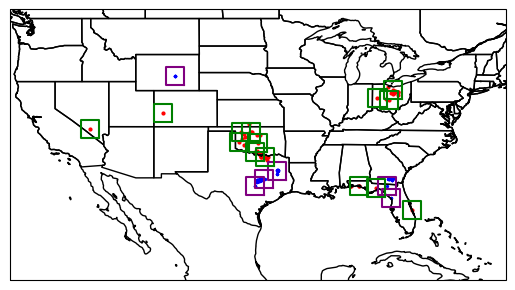

surrogate neighborhoods 6
storm report neighborhoods 14
hits 2, misses 12, false alarms 6


In [195]:
tw.plot('wind')
hits, misses, false_alarms = tw.analysis('wind')
print(f"hits {hits}, misses {misses}, false alarms {false_alarms}")

In [168]:
time_window_reports = bin_reports
time_window_start = bins[0]
print(time_window_start)
r.fetch_model_outputs()

2023-06-15 00:00:00


In [199]:
init_hour = pd.Timestamp(time_window_start) - pd.Timedelta(hours=3)
f_hour = 3
model_outputs = r.fetch_model_outputs(
    init_hour, 
    [f_hour]
)
print(model_outputs[0].MXUPHL_P8_2L103_GLC0_max1h[1])

<xarray.DataArray 'MXUPHL_P8_2L103_GLC0_max1h' (ygrid_0: 1059, xgrid_0: 1799)>
[1905141 values with dtype=float32]
Coordinates:
    gridlat_0  (ygrid_0, xgrid_0) float32 ...
    gridlon_0  (ygrid_0, xgrid_0) float32 ...
Dimensions without coordinates: ygrid_0, xgrid_0
Attributes: (12/13)
    center:                                         US National Weather Servi...
    production_status:                              Operational products
    long_name:                                      Hourly maximum of updraft...
    units:                                          m2 s-2
    grid_type:                                      Lambert Conformal can be ...
    parameter_discipline_and_category:              Meteorological products, ...
    ...                                             ...
    level_type:                                     Specified height level ab...
    type_of_statistical_processing:                 Maximum
    statistical_process_duration:                   1 hour

[1, 2, 3, 4]